In [13]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

import softclustering as sc
import socceraction.spadl as spadl

### Load data
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


64it [00:00, 201.28it/s]


Remove 532 out of 128484 datapoints.


In [14]:
actions_final = actions[(actions["team_id"]==771) & (actions["game_id"]==8658)]
actions_final

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,is_home,type_name,angle,cos_angle,sin_angle
78215,8658,1,13.627,771,5485.0,41.234412,25.069709,41.602627,17.427088,0,0,0,9,True,pass,-1.522654,0.048123,-0.998841
78240,8658,1,44.267,771,5485.0,30.527459,23.433091,42.437500,0.425000,18,1,0,34,True,clearance,-1.093132,0.459706,-0.888071
78241,8658,1,54.747,771,5476.0,42.437500,0.425000,39.952616,16.347084,2,1,2,35,True,throw_in,1.725613,-0.154199,0.988040
78242,8658,1,56.147,771,3961.0,39.801938,16.783077,56.523945,13.040199,21,1,0,36,True,dribble,-0.220200,0.975854,-0.218425
78243,8658,1,56.507,771,3961.0,57.104666,14.025659,57.139961,9.225752,0,0,5,37,True,pass,-1.563443,0.007353,-0.999973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79901,8658,2,2956.627,771,2948.0,60.474407,18.446841,83.778320,12.053738,0,0,1,1695,True,pass,-0.267749,0.964369,-0.264561
79904,8658,2,2966.547,771,5485.0,28.039233,16.663284,27.233890,17.313936,21,1,0,1698,True,dribble,2.462041,-0.777855,0.628444
79905,8658,2,2967.307,771,5485.0,26.417540,16.881289,58.939358,0.230429,0,0,4,1699,True,pass,-0.473194,0.890117,-0.455732
79911,8658,2,2985.427,771,3099.0,3.856647,40.972741,3.908131,41.147539,15,1,2,1705,True,keeper_action,1.284364,0.282532,0.959258


In [15]:
loc_pass = actions_final[actions_final["type_name"]=="pass"][["start_x","start_y"]]
dir_pass = actions_final[actions_final["type_name"]=="pass"][["cos_angle","sin_angle"]]

In [22]:
loc_pass.size

484

Clusters 2, BIC score 5176.98


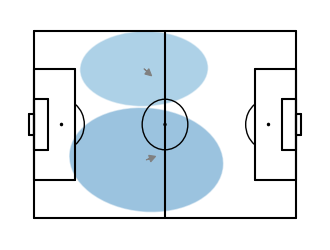

Clusters 6, BIC score 5181.17


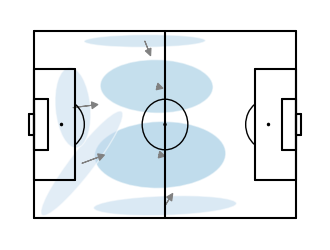

Clusters 10, BIC score 5232.03


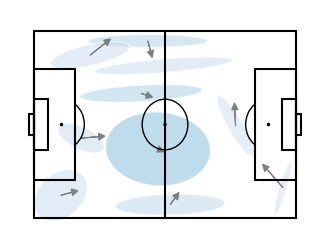

Clusters 14, BIC score 5406.27


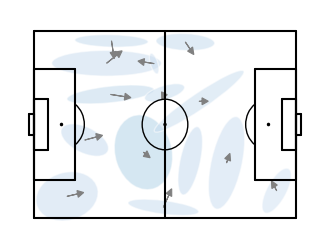

Clusters 18, BIC score 5504.25


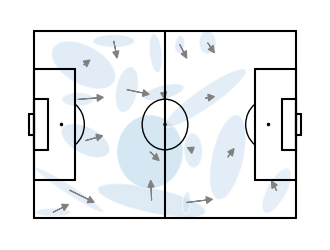

Clusters 23, BIC score 5611.71


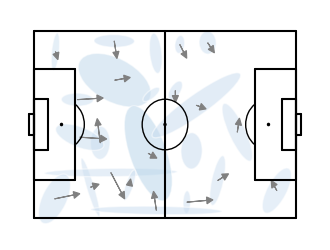

Clusters 27, BIC score 5691.01


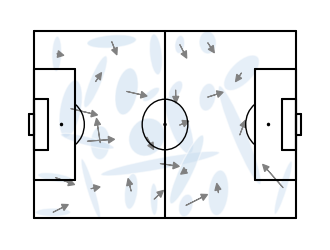

Clusters 31, BIC score 5694.55


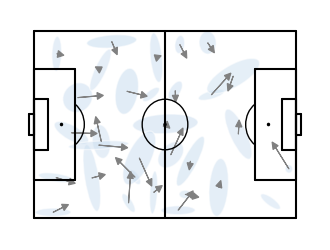

Clusters 35, BIC score 5690.08


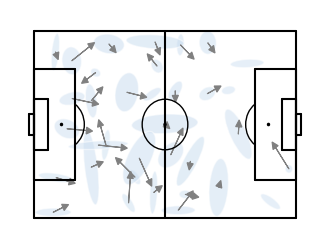

Clusters 40, BIC score 5659.64


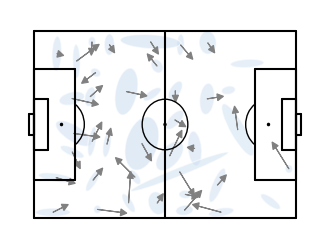

In [21]:
for k in np.linspace(2,40,10,dtype=int):
    oneshot_model = sc.OneShotScheme(n_clusters=k, alpha=1, beta=1, init="k-means++")
    oneshot_model.fit(loc_pass,dir_pass)
    print(f"Clusters {k}, BIC score {oneshot_model.bic_score(loc_pass, dir_pass):.2f}")
    oneshot_model.plot(figsize=4)

Clusters 2, BIC score 5217.32


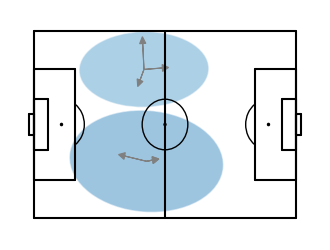

Clusters 6, BIC score 5342.58


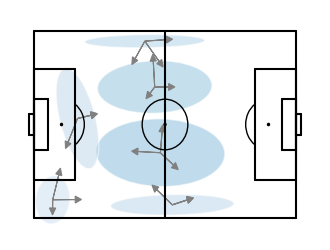

Clusters 10, BIC score 5579.28


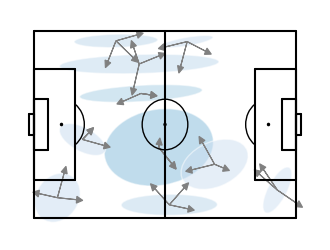

Clusters 14, BIC score 5855.27


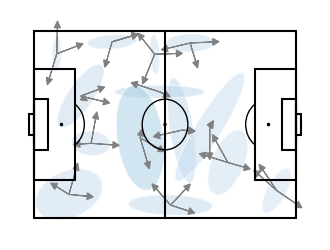

Clusters 18, BIC score 5975.73


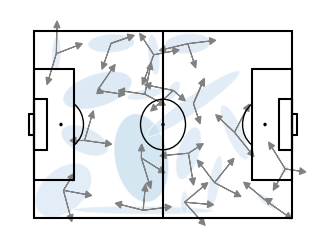

Clusters 23, BIC score 6341.73


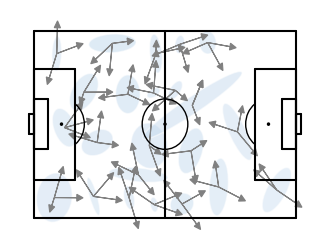

Clusters 27, BIC score 6592.09


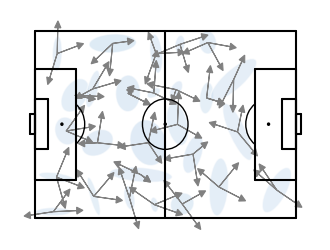

Clusters 31, BIC score 6787.93


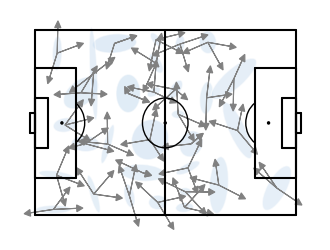

Clusters 35, BIC score 6857.64


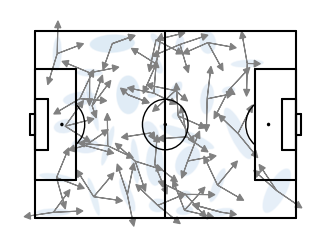

Clusters 40, BIC score 6929.94


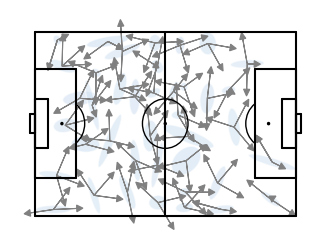

In [23]:
for k in np.linspace(2,40,10,dtype=int):
    K_dir = [3 for _ in range(k)]
    init = "k-means++"
    loc_mixture = sc.MixtureModel(
                [sc.MultivariateGaussian() for _ in range(k)],
                init=init
            )
    dir_mixtures = [ sc.MixtureModel(
                        [sc.VonMises() for _ in range(K_dir[j])],
                        init=init
                        )
                     for j in range(k)]

    twolayer_model = sc.TwoLayerScheme(loc_mixture, dir_mixtures)
    twolayer_model.fit(loc_pass, dir_pass)
    print(f"Clusters {k}, BIC score {twolayer_model.bic_score(loc_pass, dir_pass):.2f}")
    twolayer_model.plot(figsize=4)